In [1]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#@title Synthetic data
def set_npseed(seed):
  np.random.seed(seed)
  random.seed(seed)

def set_torchseed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  

def data_gen(num_train_data,num_vali_data,num_test_data,dim=2,seed=0):
  # np.random.seed(6790)
  set_npseed(seed = seed)
  d=dim
  num_modes=2*d
  centers = np.concatenate((np.eye(d), -1*np.eye(d)), axis=0)
  np.random.shuffle(centers)
  # np.random.seed(475)
  hard=num_modes//2

  a=[4]* hard + [1]*(num_modes - hard)
  mode_frac = np.array([1./num_modes]*num_modes)
  b=1.
  num_train_data = num_train_data 
  num_vali_data=num_vali_data
  num_test_data=num_test_data
  num_data = num_train_data + num_vali_data + num_test_data

  num_data_per_mode = np.int32(num_data*mode_frac)
  num_data_per_mode = np.concatenate((num_data_per_mode,[np.sum(num_data_per_mode)]))

  landmarks=[-1]*num_modes
  labels=[-1]*num_modes
  for i in range(num_modes):
    landmarks[i] = 0.05*np.random.randn(a[i],d)
    landmarks[i]+=centers[i]
    labels[i] = (i - np.arange(len(landmarks[i])))%2
      
  data=[-1]*num_modes
  data_labels=[-1]*num_modes

  train_data=[-1]*num_modes
  train_data_labels=[-1]*num_modes

  test_data=[-1]*num_modes
  test_data_labels=[-1]*num_modes

  vali_data=[-1]*num_modes
  vali_data_labels=[-1]*num_modes


  modes_data=[]
  # np.random.seed(12345)

  for i in range(num_modes):
    data[i] = 0.1*np.random.randn(num_data_per_mode[i],d)
    data[i] += centers[i]
    data_labels[i] = np.zeros(num_data_per_mode[i])
    for j in range(len(data_labels[i])):
      dists = pairwise_distances(data[i][j:j+1,:],landmarks[i])                                   
      j_star = np.argmin(dists[0])
      data_labels[i][j]=labels[i][j_star]
      
      train_data[i] = np.array(data[i][:int(mode_frac[i]*num_train_data)])
      train_data_labels[i] = np.array(data_labels[i][:int(mode_frac[i]*num_train_data)])

      vali_data[i] = np.array(data[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])
      vali_data_labels[i] = np.array(data_labels[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])

      test_data[i] = np.array(data[i][-int(mode_frac[i]*num_test_data):])
      test_data_labels[i] = np.array(data_labels[i][-int(mode_frac[i]*num_test_data):])
      
  return data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels,landmarks,labels,centers,mode_frac

In [3]:
#@title DLGN_FC
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DLGN_FC(nn.Module):
  def __init__(self, to_copy=None, num_hidden_layers=0, input_dim=2, output_dim=1, num_hidden_nodes=[], beta=20, mode='pwc'):
    super(DLGN_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = num_hidden_layers
      self.beta=beta  # Soft gating parameter
      self.mode = mode
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
    else:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.beta=to_copy.beta  # Soft gating parameter
      self.mode = to_copy.mode
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
        self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].weight.detach().numpy()))
        self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].bias.detach().numpy()))
        self.value_layers[i].weight.data = torch.Tensor(np.array(to_copy.value_layers[i].weight.detach().numpy()))

                

  def return_gating_functions(self):
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              

  def forward(self, x):
    gate_scores=[x]
    if self.mode=='pwc':
      values=[torch.ones(x.shape)]
    else:
      values=[x]
    
    for i in range(self.num_hidden_layers):
      gate_scores.append(self.gating_layers[i](gate_scores[-1]))
      curr_gate_on_off = torch.sigmoid(self.beta*gate_scores[-1])
      values.append(self.value_layers[i](values[-1])*curr_gate_on_off)
    values.append(self.value_layers[self.num_hidden_layers](values[-1]))
    # Values is a list of size 1+num_hidden_layers+1
    #gate_scores is a list of size 1+num_hidden_layers
    return values,gate_scores

Using cpu device


In [4]:
# Python program to check whether the given
def perfectSq(N) :
	sq_root = round(N**(1/2));
	if sq_root * sq_root == N :
		return True;
	else :
		return False;

In [5]:
#@title Train DLGN model based on freeze nodes
def train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,no_of_batches,
               mode,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze):
  # torch.random.manual_seed(1222)
  # torch.random.manual_seed(2311)
  layer_num=layer_num-1
  node_num=node_num-1
  set_torchseed(seed)
  if freeze:
    DLGN_obj_initial = None
  DLGN_obj = None
  DLGN_obj_return = None
  
  DLGN_obj = DLGN_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                      num_hidden_nodes=num_hidden_nodes, beta=beta, mode=mode)
  if freeze:
    DLGN_obj_initial = DLGN_FC(to_copy=DLGN_obj)
  
  DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)
  criterion = nn.CrossEntropyLoss()
  DLGN_params = []
  DLGN_params += [item.weight for item in DLGN_obj.gating_layers]
  DLGN_params += [item.bias for item in DLGN_obj.gating_layers]
  DLGN_params += [item.weight for item in DLGN_obj.value_layers]
#     DLGN_params += [item.bias for item in DLGN_obj.value_layers]

  # print("H0")
  # print(DLGN_params)
  if freeze:
    for index,param in enumerate(DLGN_params):
      if((index != layer_num)):
        param.requires_grad=False
      if((index==len(DLGN_obj.gating_layers)+layer_num)):
        param.requires_grad=True

  # print("H1")
  # print(DLGN_params)

  optimizer = optim.Adam(DLGN_params, lr=0.00005, weight_decay=0.0)
  

  # print("H2")
  # print(DLGN_params)
  
  train_data_torch = torch.Tensor(train_data_curr)
  vali_data_torch = torch.Tensor(vali_data_curr)
  test_data_torch = torch.Tensor(test_data_curr)

  train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
  test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
  vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)
  num_batches = no_of_batches
  batch_size = len(train_data_curr)//num_batches
  losses=[]
  DLGN_obj_store = []
  best_vali_error = len(vali_labels_curr)

  # print("H3")
  # print(DLGN_params)

  for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
    running_loss = 0.0
    if perfectSq(epoch):
      DLGN_obj_store.append(DLGN_FC(to_copy=DLGN_obj))
    
    for batch_start in range(0,len(train_data_curr),batch_size):
      optimizer.zero_grad()
      values,gate_scores = DLGN_obj(train_data_torch[batch_start:batch_start+batch_size])
      outputs = torch.cat((values[-1], -1*values[-1]), dim=1)
      loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size])

      # print("H4")
      # print(DLGN_params)

      loss.backward()
      optimizer.step()

      # print("H5")
      # print(DLGN_params)
      if freeze:
        for node in range(num_hidden_nodes[layer_num]):
          if(node!=node_num):
            # self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].weight.detach().numpy()))
            DLGN_params[layer_num].data[node]= DLGN_obj_initial.gating_layers[layer_num].weight.data[node]
            DLGN_params[len(DLGN_obj.gating_layers)+layer_num].data[node]= DLGN_obj_initial.gating_layers[layer_num].bias.data[node]

      # print("H6")
      # print(DLGN_params)

      running_loss += loss.item()    
    losses.append(running_loss/num_batches)

    values,gate_scores =DLGN_obj(vali_data_torch)
    vali_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
    vali_error= torch.sum(vali_labels_torch!=torch.argmax(vali_preds, dim=1)).numpy()
    
    if vali_error < best_vali_error:
      DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)
      best_vali_error = vali_error
    
  values,gate_scores =DLGN_obj_return(test_data_torch)
  test_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
  test_error= torch.sum(test_labels_torch!=torch.argmax(test_preds, dim=1)).numpy()

  values,gate_scores=DLGN_obj_return(train_data_torch)
  train_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
  train_error= torch.sum(train_labels_torch!=torch.argmax(train_preds, dim=1)).numpy()
  plt.figure()
  plt.title("DLGN loss vs epoch")
  plt.plot(losses)
  return test_error, train_error, torch.argmax(test_preds, dim=1).numpy(), DLGN_obj_return, DLGN_obj_store

**Generating data**

In [6]:
num_train_data=2400
num_vali_data=2400
num_test_data=2400
dim=2
num_modes=2*dim
seed=365
data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels, \
landmarks,labels,centers,mode_frac= data_gen(num_train_data,num_vali_data,num_test_data,dim=2,seed=0)

**Plotting the data**

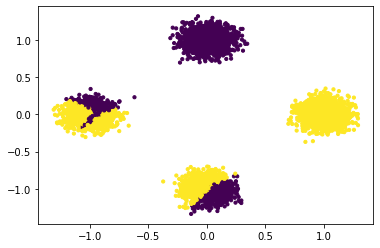

In [7]:
fig=plt.scatter(np.concatenate(data)[:,0], np.concatenate(data)[:,1], c=np.concatenate(data_labels), s=10)

**Training a DLGN model**

Num Train =  2400
Num Vali  =  2400
Num Test  =  2400
==========DLGN===========


100%|██████████| 2000000/2000000 [1:14:49<00:00, 445.47it/s]


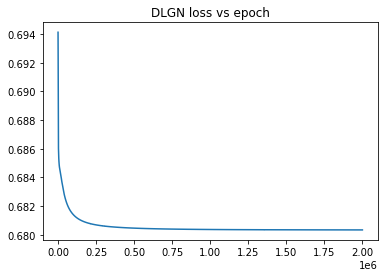

In [8]:
## Convention 0th layer is input layer 1st layer is 1st hidden layer and last layer is output layer
## so 3 hidden layers mean 1 input node + 3 hidden layers + 1 output layer
seed=0
num_hidden_layers=3
input_dim=dim
output_dim=1
num_hidden_nodes=[3,3,3]
max_no_of_nodes=max(num_hidden_nodes)
beta=20
no_of_batches=1 #[1,10,100]
modep='pwc'

freeze = True
layer_num = 3
node_num = 2

num_epoch=2000000

train_data_curr = np.concatenate(train_data[0:num_modes])
train_labels_curr = np.concatenate(train_data_labels[0:num_modes])
vali_data_curr = np.concatenate(vali_data[0:num_modes])
vali_labels_curr = np.concatenate(vali_data_labels[0:num_modes])
test_data_curr = np.concatenate(test_data[0:num_modes])
test_labels_curr = np.concatenate(test_data_labels[0:num_modes])

print("Num Train = ",len(train_data_curr))
print("Num Vali  = ",len(vali_data_curr))
print("Num Test  = ",len(test_data_curr))
print("==========DLGN===========") 
test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
               no_of_batches,modep,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze)    

**Check node freezing**

In [9]:
epoch=len(DLGN_obj_store)
value = np.zeros((epoch,num_hidden_layers,max_no_of_nodes))

for index,model in enumerate(DLGN_obj_store):
  for i in range(len(model.gating_layers)-1):
    for j in range(len(model.gating_layers[i].weight)):
      value[index][i][j]=model.gating_layers[i].weight[j].data.detach().numpy().mean(axis=0)

In [10]:
epoch_count=range(epoch)

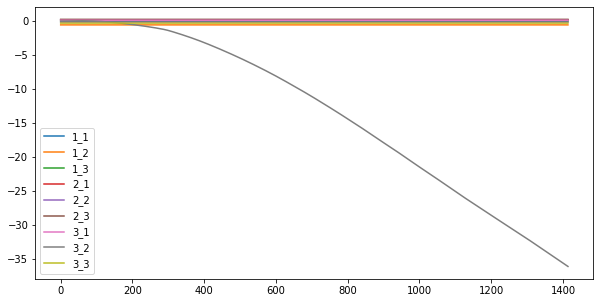

In [11]:
plt.figure(figsize=(10, 5))
for i in range(value[0].shape[0]):
  for j in range(value[0].shape[1]):
    plt.plot(epoch_count,value[:,i,j],label=str(i+1)+"_"+str(j+1))
    plt.legend()

In [12]:
print("test_error",test_error/len(test_data_curr))
print("train_error",train_error/len(train_data_curr))
print('DLGN acc=',np.sum(predictions_dlgn==test_labels_curr)/len(test_data_curr))

test_error 0.39416666666666667
train_error 0.3925
DLGN acc= 0.6058333333333333


**Data vs prediction scatter plot**

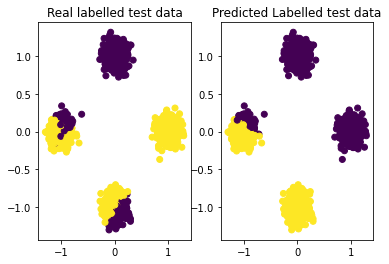

In [13]:
plt.figure()
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(test_data_curr[:,0], test_data_curr[:,1], c=test_labels_curr)
plt.title("Real labelled test data")

plt.subplot(1, 2, 2) # index 2
plt.scatter(test_data_curr[:,0], test_data_curr[:,1], c=predictions_dlgn)
plt.title("Predicted Labelled test data")
plt.show()

**Gating pattern per layer with best model**

In [ ]:
effective_weights, effective_biases = DLGN_obj_final.return_gating_functions()
X=test_data_curr[:,0]
Y=test_data_curr[:,1]
no_rows=num_hidden_layers+1
no_colns = max_no_of_nodes
fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
fig.tight_layout(pad=2)
fig.text(0,0,s="Best Epoch")
for k in range(no_colns//2):
  im_hide = ax[0,k].axis('off')
im0=ax[0,no_colns//2].scatter(X, Y, c=test_labels_curr,vmin=0,vmax=1)
ax[0,no_colns//2].title.set_text("Real")
ax[0,no_colns//2].set_xlim(-2,2)
ax[0,no_colns//2].set_ylim(-4,4)
divider = make_axes_locatable(ax[0,no_colns//2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
im1=ax[0,no_colns//2+1].scatter(X, Y, c=predictions_dlgn,vmin=0,vmax=1)
ax[0,no_colns//2+1].title.set_text("Predicted")
ax[0,no_colns//2+1].set_xlim(-2,2)
ax[0,no_colns//2+1].set_ylim(-4,4)
divider = make_axes_locatable(ax[0,no_colns//2+1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
for j in range(num_hidden_layers):
  for i in range( num_hidden_nodes[j]):
    weight = effective_weights[j][i].data.numpy()
    bias = effective_biases[j][i].data.numpy()
    Z = ((test_data_curr@weight.T)+bias)>0
    line_eq = (-bias - X*weight[0])/weight[1]
    im=ax[j+1,i].scatter(X, Y, c=Z,vmin=0,vmax=1)
    im1=ax[j+1,i].plot(X,line_eq,label="("+str(round(weight.data[0],4))+")x+"+"("+str(round(weight.data[1],4))+")y+"+"("+str(round(bias.item(),2))+")=0")
    ax[j+1,i].set_xlim(-2,2)
    ax[j+1,i].set_ylim(-4,4)
    ax[j+1,i].title.set_text("Layer: "+str(j+1)+" Node: "+str(i+1))
    ax[j+1,i].legend()
    divider = make_axes_locatable(ax[j+1,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.82])
# fig.colorbar(im0, cax=cbar_ax)
path0="/content/drive/MyDrive/Research/DLGN_fixed_node/"
fig.savefig(str(path0)+"Best_epoch.pdf", dpi=300,format="pdf")


**Change of gating pattern for each layers per 10 epoch**

In [15]:
# Python program to check whether the given
def perfectCube(N) :
	cube_root = round(N**(1/3));
	if cube_root * cube_root * cube_root == N :
		return True;
	else :
		return False;

In [16]:
path1="/content/drive/MyDrive/Research/DLGN_fixed_node/Layer1/"
path2="/content/drive/MyDrive/Research/DLGN_fixed_node/Layer2/"
path3="/content/drive/MyDrive/Research/DLGN_fixed_node/Layer3/"

In [ ]:
for epoch_no in range(len(DLGN_obj_store)):
  if (epoch_no%100==0):
    print("________________________________")
    print("=======Epoch no: ", epoch_no**2)
    print("________________________________")



    effective_weights, effective_biases = DLGN_obj_store[epoch_no].return_gating_functions()
    X=test_data_curr[:,0]
    Y=test_data_curr[:,1]
    test_data_torch = torch.Tensor(test_data_curr)
    values,gate_scores =DLGN_obj_store[epoch_no](test_data_torch)
    test_preds = torch.cat((values[-1], -1*values[-1]), dim=1)
    predictions=torch.argmax(test_preds, dim=1).numpy()

    no_rows=num_hidden_layers+1
    no_colns = max_no_of_nodes
    fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
    fig.tight_layout(pad=2)
    fig.text(0,0,s="Epoch no: "+ str(epoch_no**2))
    for k in range(no_colns//2):
      im_hide = ax[0,k].axis('off')
    im0=ax[0,no_colns//2].scatter(X, Y, c=test_labels_curr,vmin=0,vmax=1)
    ax[0,no_colns//2].title.set_text("Real")
    ax[0,no_colns//2].set_xlim(-2,2)
    ax[0,no_colns//2].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')

    im1=ax[0,no_colns//2+1].scatter(X, Y, c=predictions,vmin=0,vmax=1)
    ax[0,no_colns//2+1].title.set_text("Predicted")
    ax[0,no_colns//2+1].set_xlim(-2,2)
    ax[0,no_colns//2+1].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    for j in range(num_hidden_layers):
      for i in range( num_hidden_nodes[j]):
        weight = effective_weights[j][i].data.numpy()
        bias = effective_biases[j][i].data.numpy()
        Z = ((test_data_curr@weight.T)+bias)>0
        line_eq = (-bias - X*weight[0])/weight[1]

        im=ax[j+1,i].scatter(X, Y, c=Z,vmin=0,vmax=1)
        im1=ax[j+1,i].plot(X,line_eq,label="("+str(round(weight.data[0],4))+")x+"+"("+str(round(weight.data[1],4))+")y+"+"("+str(round(bias.item(),4))+")=0")
        ax[j+1,i].set_xlim(-2,2)
        ax[j+1,i].set_ylim(-4,4)
        ax[j+1,i].title.set_text("Layer: "+str(j+1)+" Node: "+str(i+1))
        ax[j+1,i].legend()
        divider = make_axes_locatable(ax[j+1,i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.82])
    # fig.colorbar(im0, cax=cbar_ax)
    path="/content/drive/MyDrive/Research/DLGN_fixed_node/Layer_3_Node_2/"
    fig.savefig(str(path)+"Epoch_"+str(epoch_no**2)+"_.png", dpi=300)
    # fig.savefig(str(path)+"Epoch_"+str(epoch_no**2)+"_layer_"+str(j+1)+" Node: "+str(i+1)+"_.pdf", dpi=300,format="pdf")
    plt.show